In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import  *
from matplotlib import pyplot as plt
from wordcloud import WordCloud

from sklearn.model_selection import GridSearchCV


## EDA

In [2]:
df = pd.read_csv("./data/labeled.csv", sep=',')

In [3]:
df.shape

(14412, 2)

In [4]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [5]:
df["toxic"] = df["toxic"].apply(int)

In [6]:
df["toxic"].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [7]:
for c in df[df["toxic"] == 1]["comment"].head(5):
    print(c)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [8]:
for c in df[df["toxic"] == 0]["comment"].head(5):
    print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [9]:
df[df["toxic"] == 0]["comment"].isna().sum()

0

## Text preprocessing


In [10]:
example = df.iloc[1]["comment"]
tokens = word_tokenize(example, language="russian")
tokens_without_punct = [i for i in tokens if i not in string.punctuation]
stop_words = stopwords.words("russian")

tokens_without_punct_and_stopwords = [i for i in tokens_without_punct if i not in stop_words]
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_punct_and_stopwords]


print(f"Исходный текст: {example}")
print("-----------------")
print(f"Токены: {tokens}")
print("-----------------")
print(f"Токены без пунктуации: {tokens_without_punct}")
print("-----------------")
print(f"Токены без пунктуации и стоп слов: {tokens_without_punct_and_stopwords}")
print("-----------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("-----------------")

Исходный текст: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

-----------------
Токены: ['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
-----------------
Токены без пунктуации: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
-----------------
Токены без пунктуации и стоп слов: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
-----------------
Токены после стемминга: ['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисел', 'придума']
-----------------


In [11]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [12]:
train_df, test_df = train_test_split(df, test_size = 500, random_state=234)
print(train_df.shape)
print(test_df.shape)


(13912, 2)
(500, 2)


In [13]:
# сравним распределение целевого признака
for sample in [train_df, test_df]:
    print(sample[sample['toxic'] == 1].shape[0] / sample.shape[0])

0.3356095457159287
0.314


In [14]:
train_df["toxic"].value_counts()

0    9243
1    4669
Name: toxic, dtype: int64

In [15]:
print(train_df.shape)
print(test_df.shape)

(13912, 2)
(500, 2)


## TF - IDF

In [16]:
count_idf_positive = TfidfVectorizer(ngram_range = (1,1), tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))
count_idf_negative = TfidfVectorizer(ngram_range = (1,1), tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

tf_idf_positive = count_idf_positive.fit_transform(train_df.query('toxic == 1')['comment'])
tf_idf_negative = count_idf_negative.fit_transform(train_df.query('toxic == 0')['comment'])

/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [17]:
# Сохраним списки Idf для каждого класса
positive_importance = pd.DataFrame(
    {'word' : count_idf_positive.get_feature_names_out(),
     'idf' : count_idf_positive.idf_
    }).sort_values(by = 'idf', ascending = False)

negative_importance = pd.DataFrame(
    {'word' : count_idf_negative.get_feature_names_out(),
     'idf' : count_idf_negative.idf_
    }).sort_values(by = 'idf', ascending = False)

In [18]:
positive_importance.query('word not in @negative_importance.word and idf < 10.8')

,word,idf
9952,перефразирова,8.755767
9955,перехуяр,8.755767
9966,пернув,8.755767
9967,пернул,8.755767
9968,пернут,8.755767
...,...,...
7060,малолетн,5.983178
16081,хохол,5.865395
12863,русн,5.536891
3615,дегенерат,5.371377


In [19]:
negative_importance.query('word not in @positive_importance.word and idf < 10')

,word,idf
20959,рига-13,9.438583
10988,константин,9.438583
10989,константинович,9.438583
10991,констатац,9.438583
10992,констатир,9.438583
...,...,...
3526,аппарат,6.468168
13420,нагрузк,6.442851
4400,брал,6.347540
23793,температур,6.088679


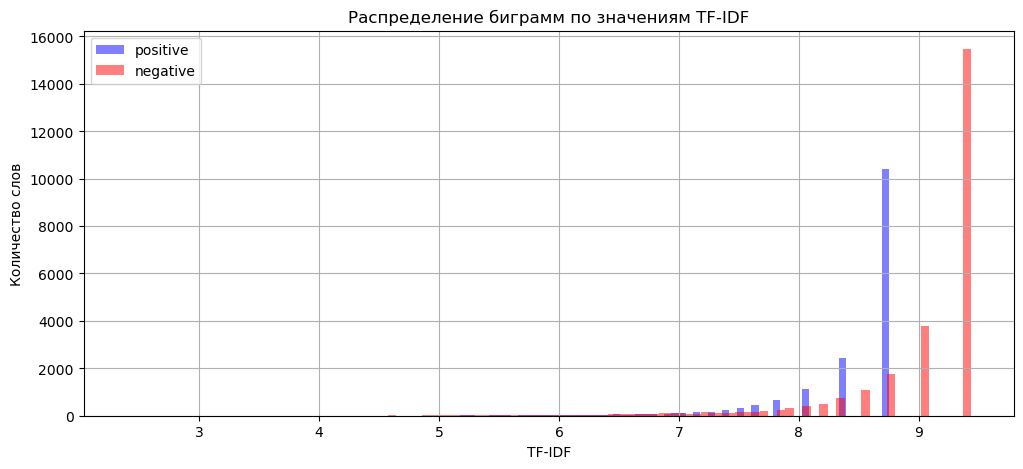

In [20]:
fig = plt.figure(figsize = (12,5))
positive_importance.idf.hist(bins = 100,
                             label = 'positive',
                             alpha = 0.5,
                             color = 'b',
                            )
negative_importance.idf.hist(bins = 100,
                             label = 'negative',
                             alpha = 0.5,
                             color = 'r',
                            )
plt.title('Распределение биграмм по значениям TF-IDF')
plt.xlabel('TF-IDF')
plt.ylabel('Количество слов')
plt.legend()
plt.show()

## Пред обучение моделей

In [21]:
count_idf_1 = TfidfVectorizer(ngram_range = (1,1), tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))
tf_idf_base_1 = count_idf_1.fit(df['comment'])
tf_idf_train_base_1 = count_idf_1.transform(train_df['comment'])
tf_idf_test_base_1 = count_idf_1.transform(test_df['comment'])

/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [22]:
print(tf_idf_train_base_1.shape)
print(tf_idf_test_base_1.shape)


(13912, 36122)
(500, 36122)


In [23]:
sample = test_df.sample(n=1)['comment']
sample_tf_idf = count_idf_1.transform(sample)
sample_tf_idf.shape

(1, 36122)

In [24]:
array = sample_tf_idf.toarray()
array

array([[0., 0., 0., ..., 0., 0., 0.]])

In [25]:
sample

12391    Что касается 3 млн, у Кия самая дорогая машина...
Name: comment, dtype: object

In [26]:
array[array!= 0]

array([0.27552192, 0.25845753, 0.24785363, 0.19574676, 0.13724815,
       0.25845753, 0.13854953, 0.21636683, 0.18436214, 0.2040751 ,
       0.25845753, 0.23449431, 0.13459448, 0.37887959, 0.20099479,
       0.14063173, 0.15832929, 0.10074052, 0.11669742, 0.25845753,
       0.25845753, 0.06473031])

In [27]:
model_lr_base_1 = LogisticRegression(solver='lbfgs', random_state=234, max_iter= 10000,
                                    n_jobs= -1)

Получим прогноз и оценим качество модели

In [28]:
model_lr_base_1.fit(tf_idf_train_base_1, train_df['toxic'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=234)

In [29]:
predict_lr_base_proba = model_lr_base_1.predict_proba(tf_idf_test_base_1)

In [30]:
predict_lr_base_proba

array([[0.85603587, 0.14396413],
       [0.29448938, 0.70551062],
       [0.41543358, 0.58456642],
       [0.77011541, 0.22988459],
       [0.62820949, 0.37179051],
       [0.53626921, 0.46373079],
       [0.90425945, 0.09574055],
       [0.91212485, 0.08787515],
       [0.7154839 , 0.2845161 ],
       [0.82565931, 0.17434069],
       [0.94387436, 0.05612564],
       [0.59381989, 0.40618011],
       [0.10508707, 0.89491293],
       [0.44582691, 0.55417309],
       [0.67664003, 0.32335997],
       [0.82650196, 0.17349804],
       [0.8834312 , 0.1165688 ],
       [0.69639802, 0.30360198],
       [0.58993745, 0.41006255],
       [0.31209755, 0.68790245],
       [0.50352636, 0.49647364],
       [0.40041153, 0.59958847],
       [0.87135547, 0.12864453],
       [0.19528851, 0.80471149],
       [0.27197785, 0.72802215],
       [0.79897087, 0.20102913],
       [0.84889886, 0.15110114],
       [0.82644453, 0.17355547],
       [0.68546776, 0.31453224],
       [0.65366035, 0.34633965],
       [0.

Сравним с классификатором случайного числа от 0 до 1

In [31]:
def coin_classifier(X:np.array) -> np.array:
    predict = np.random.uniform(0.0, 1.0, X.shape[0])
    return predict

In [32]:
coin_predict = coin_classifier(tf_idf_test_base_1)

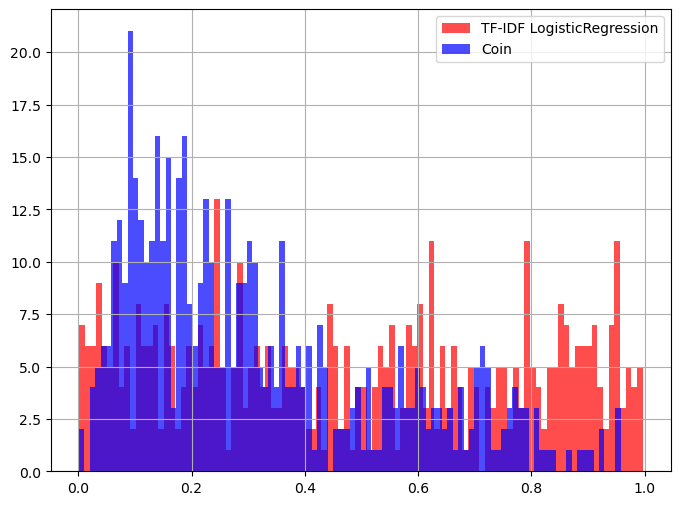

In [33]:
fif = plt.figure(figsize = (8, 6))

pd.Series(coin_predict)\
                .hist(bins = 100,
                      alpha = 0.7,
                      color = 'r',
                      label = 'TF-IDF LogisticRegression'
                     )

pd.Series(predict_lr_base_proba[:, 1])\
                .hist(bins = 100,
                      alpha = 0.7,
                      color = 'b',
                      label = 'Coin'
                     )
plt.legend()   
plt.show()

## Визуализация ROC

In [34]:
fpr_base, tpr_base, _ = roc_curve(test_df['toxic'], predict_lr_base_proba[:, 1])
roc_auc_base = auc(fpr_base, tpr_base)

In [35]:
fpr_coin, tpr_coin, _ = roc_curve(test_df['toxic'], coin_predict)
roc_auc_coin = auc(fpr_base, tpr_base)

In [36]:
fig = make_subplots(1,1,
                    subplot_titles = ["Receiver operating characteristic"],
                    x_title="False Positive Rate",
                    y_title = "True Positive Rate"
                   )



fig.add_trace(go.Scatter(
    x = fpr_base,
    y = tpr_base,
    #fill = 'tozeroy',
    name = "ROC base (area = %0.3f)" % roc_auc_base,
    ))

fig.add_trace(go.Scatter(
    x = fpr_coin,
    y = tpr_coin,
    mode = 'lines',
    line = dict(dash = 'dash'),
    name = 'Coin classifier (area = 0.5)'
    ))


fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    template = 'plotly_dark',
    font_color = 'rgba(212, 210, 210, 1)'
    )

In [37]:
# матрицва ошибок
confusion_matrix(test_df['toxic'],
                 (predict_lr_base_proba[:, 1] > 0.5).astype('float'),
                 normalize='true',
                )

array([[0.97959184, 0.02040816],
       [0.35031847, 0.64968153]])

## Важность признака

In [38]:
# Получим веса признаков, то есть множители 
# подобранные логистической регрессией 
# для каждого компонента вектора tf-idf

weights = pd.DataFrame({'words': count_idf_1.get_feature_names_out(),
                        'weights': model_lr_base_1.coef_.flatten()})
weights_min = weights.sort_values(by= 'weights')
weights_max = weights.sort_values(by= 'weights', ascending = False)

In [39]:
weights_min = weights_min[:100]
weights_min['weights'] = weights_min['weights'] * -1
weights_min

,words,weights
8584,год,3.306079
30134,спасиб,3.263017
21390,очен,3.090341
8722,город,2.950891
34545,цен,2.832895
...,...,...
27058,раньш,1.312506
290,10,1.310252
24743,поэт,1.307031
33084,услов,1.306304


In [40]:
weights_max = weights_max[:100]
weights_max

,words,weights
34266,хохл,6.732114
32283,туп,4.305728
28105,русск,4.283906
35320,шлюх,4.018781
31446,теб,3.844885
...,...,...
34376,хрюка,1.527615
5003,бел,1.519621
4823,бат,1.512583
4195,анон,1.486509


In [41]:
# Воспользуемся библиотекой wordcloud для генерации картинок

wordcloud_positive = WordCloud(background_color="white",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_max.values))

wordcloud_negative = WordCloud(background_color="black",
                               colormap = 'Reds',
                               max_words=200,
                               mask=None, 
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_min.values))

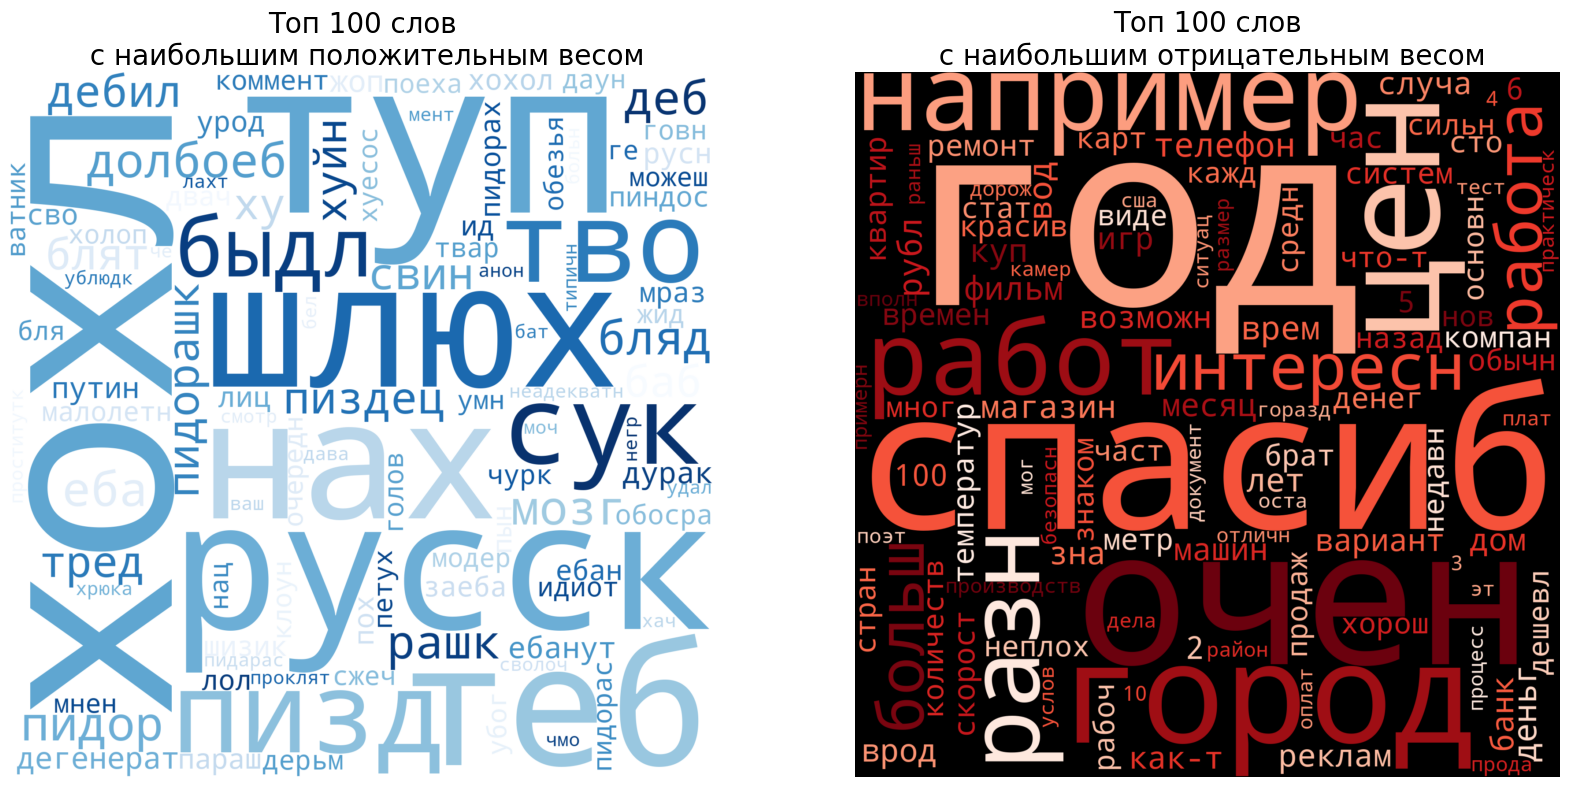

In [42]:
# Выведем картинки сгенерированные вордклаудом
fig, ax = plt.subplots(1, 2, figsize = (20, 12))


ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[1].imshow(wordcloud_negative, interpolation='bilinear')

ax[0].set_title('Топ ' +\
                str(weights_max.shape[0]) +\
                ' слов\n с наибольшим положительным весом',
               fontsize = 20
               )
ax[1].set_title('Топ ' +\
                str(weights_min.shape[0]) +\
                ' слов\n с наибольшим отрицательным весом',
               fontsize = 20
               )

ax[0].axis("off")
ax[1].axis("off")

plt.show()

## Снижение размерности признакового пространства модели

In [43]:
fig = make_subplots(1,1)

fig.add_trace(go.Histogram(
    x = weights.query('weights != 0')['weights'],
    #histnorm = 'probability',
    opacity = 0.5,
    showlegend = False
))

fig.add_trace(go.Histogram(
    x = weights.query('weights > 0.25 or weights < -0.25')['weights'],
    #histnorm = 'probability',
    opacity = 0.5,
    showlegend = False
))

fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    template = 'plotly_dark',
    font_color = 'rgba(212, 210, 210, 1)'
    
)

In [44]:
vocab = weights.query('weights > 0.25 or weights < -0.25')['words']
vocab

4            --
27           -7
92        -ться
101          -я
102          ..
          ...  
36086      япон
36090    японск
36091     японц
36098    яркост
36116        яш
Name: words, Length: 5093, dtype: object

In [45]:
count_idf = TfidfVectorizer(vocabulary=vocab,
                            ngram_range=(1,1))

In [46]:
tf_idf = count_idf.fit_transform(df['comment'])

tf_idf_train = count_idf.transform(train_df['comment'])
tf_idf_test = count_idf.transform(test_df['comment'])

In [47]:
display(tf_idf_test.shape)
display(tf_idf_train.shape)

(500, 5093)

(13912, 5093)

In [48]:
model_lr_base = LogisticRegression(solver='lbfgs', random_state=234, max_iter= 10000,
                                    n_jobs= -1)

Получим прогноз и оценим качество модели на меньшей размерности

In [49]:
model_lr_base.fit(tf_idf_train, train_df['toxic'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=234)

In [50]:
predict_lr_base_proba_1 = model_lr_base.predict_proba(tf_idf_test)

In [51]:
fpr_base_1, tpr_base_1, _ = roc_curve(test_df['toxic'], predict_lr_base_proba_1[:, 1])
roc_auc_base_1 = auc(fpr_base_1, tpr_base_1)

In [52]:
fig = make_subplots(1,1,
                    subplot_titles = ["Receiver operating characteristic"],
                    x_title="False Positive Rate",
                    y_title = "True Positive Rate"
                   )

fig.add_trace(go.Scatter(
    x = fpr_base,
    y = tpr_base,
    fill = 'tozeroy',
    name = "ROC curve (area = %0.3f)" % roc_auc_base,
    ))

fig.add_trace(go.Scatter(
    x = fpr_base_1,
    y = tpr_base_1,
    fill = 'tozeroy',
    name = "Less dimensity ROC curve (area = %0.3f)" % roc_auc_base_1,
    ))

fig.add_trace(go.Scatter(
    x = fpr_coin,
    y = tpr_coin,
    mode = 'lines',
    line = dict(dash = 'dash'),
    name = 'Coin classifier'
    ))


fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    template = 'plotly_dark',
    font_color = 'rgba(212, 210, 210, 1)'
    )

кач-во значительно уменьшилось + нет смысла уменьшать размерность на данном датасете

In [53]:
scores = {}

weight = 0.55

for threshold in np.linspace(0, 1, 100):
    
    matrix = confusion_matrix(test_df['toxic'],
                 (predict_lr_base_proba[:, 0] <  threshold).astype('float'),
                 normalize='true',
                )

    score = matrix[0,0] * weight + matrix[1,1] * (1 - weight)
    
    scores[threshold] = score

In [54]:
pd.DataFrame({'true_score':scores.values(),
             'threshold':scores.keys()},
             ).sort_values(by = 'true_score', ascending = False).head()

,true_score,threshold
57,0.862901,0.575758
56,0.861979,0.565657
62,0.860175,0.626263
63,0.858231,0.636364
58,0.858091,0.585859


In [55]:
matrix = confusion_matrix(test_df['toxic'],
                 (predict_lr_base_proba[:, 0] <  0.575758).astype('int'),
                 normalize='true',
                )
matrix

array([[0.95918367, 0.04081633],
       [0.25477707, 0.74522293]])

In [56]:
# Сделаем красивый график матрицы ошибок

fig = make_subplots(1,1)

fig.add_trace(go.Heatmap(
     y = [ 'positive', 'negative'],
     x = ['predicted_negative', 'predicted_positive'],
     z = [matrix[1, :], matrix[0, :]],
     colorscale = 'PuBu'
))

fig.add_trace(go.Heatmap(
     y = [ 'positive', 'negative'],
     x = ['predicted_negative', 'predicted_positive'],
     z = [matrix[1, :], matrix[0, :]],
     colorscale = 'PuBu'
))

fig.add_annotation(x=0, y=0,
            text = "false negative " + str(round(matrix[1,0], 2)),
            showarrow=False,
            font = dict(color = 'black'),
            yshift=10)

fig.add_annotation(x=1, y=1,
            text = "false positive " + str(round(matrix[0,1], 2)),
            showarrow=False,
            font = dict(color = 'black'),
            yshift=10)

fig.add_annotation(x=1, y=0,
            text = "true positive " + str(round(matrix[1,1], 2)),
            showarrow=False,
            font = dict(color = 'white'),
            yshift=10)

fig.add_annotation(x=0, y=1,
            text = "true negative " + str(round(matrix[0,0], 2)),
            showarrow=False,
            font = dict(color = 'white'),
            yshift=10)


fig.update_layout(height = 500,
                  width = 500,
                  template = 'plotly_dark',
                  font_color = 'rgba(212, 210, 210, 1)',
                 ).show()

## Комментарии с Ютуба

### Парсинг первого (woman)

In [57]:
from selenium import webdriver
from chromedriver_py import binary_path  # это путь к chromedriver
from tqdm import tqdm
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Инициализация Chrome WebDriver с использованием chromedriver-py
driver = webdriver.Chrome(executable_path=binary_path)

# Создаем список для результатов парсинга
scrapped = []

# Указываем время ожидания в секундах и URL видео
wait = WebDriverWait(driver, 10)
driver.get("https://www.youtube.com/watch?v=Bru4DtUe_CE&t=4s")

# Задаем количество прокруток для загрузки комментариев
for item in tqdm(range(200)):
    wait.until(EC.visibility_of_element_located((By.TAG_NAME, "body"))).send_keys(Keys.END)
    time.sleep(2)

# Получаем комментарии по тэгу "#content"
for comment in wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "#content"))):
    scrapped.append(comment.text)

# Закрываем браузер
driver.quit()

100%|██████████| 200/200 [06:57<00:00,  2.09s/it]


In [58]:
len(scrapped)

1156

In [59]:
comments = []
for part in scrapped[0].split('назад'):
    split_part = part.split('\nОТВЕТИТЬ')[0].split('\n')
    if len(split_part) > 1:
        comments.append(split_part[1])

comments = comments[3:]  # удалим лишние
print(comments)

['Как здорово, что вы приглашаете для комментариев людей, непосредственно связанных с делом, психиатров, криминалистов, врачей, следователей, это максимально дополняет картину, нежели обычный подкаст', 'Какая радость, что, не успев расстроиться из-за Вашего ухода из подкаста "Дела", я узнала о том, что Вы открываете собственную лавку историй!', 'У нас соседка была. Ее изнасиловали и она сошла с ума. Родила сына и жила с матерью. Сыну было лет 25…. Когда его мать выбросилась из окна. Она была добрая…. Прекрасно помню ее, никакого вреда не было от нее, но крыша уехала((( ', '15 лет за две детские жизни с пытками и расчлененкой , и 4.5 за соучастие в этом аду.   Судья , ты как там вобще ?', 'конечно интересно как следователь говорит об изнасиловании девушки в прошлом. «это её никак не травмировало» — между мужчинами и женщинами пропасть в понимании таких вещей', '15 лет за убийство двух девочек и по 4 за соучастие (сожжение и расчленение) - супер справедливо в кавычках Детдомовские дети в

In [61]:
comments_woman = comments + scrapped[1:]
comments_woman_df = pd.DataFrame({'comment':comments_woman})

comments_woman_df.to_csv('/Users/amakarshina/Desktop/Toxic_comments/Pet-projects/Toxic_comments/data/' + 'comments_woman.csv')
comments_woman_df = comments_woman_df[comments_woman_df['comment'].str.len() > 0]
comments_woman_df

,comment
0,"Как здорово, что вы приглашаете для комментари..."
1,"Какая радость, что, не успев расстроиться из-з..."
2,У нас соседка была. Ее изнасиловали и она сошл...
3,15 лет за две детские жизни с пытками и расчле...
4,конечно интересно как следователь говорит об и...
...,...
2353,"Не фотографий, не фактов из дела, сидит и кр..."
2354,"Простите, но без слёз на телеведущую смотреть ..."
2355,"Господи, Саша, прекрати снимать про женщин. Тв..."
2356,"Скучно и нудно, и это самое популярное видео н..."


In [133]:
# Очистка текстов комментариев
start_clean = time.time()
comments_woman_df['text_clear'] = comments_woman_df['comment'].apply(lambda x: tokenize_sentence(x, remove_stop_words=True))
print('Обработка текстов заняла: ' + str(round(time.time() - start_clean, 2)) + ' секунд')

# # Проверка: убедитесь, что text_clear содержит списки токенов
# print("Списки токенов:\n", comments_man_df['text_clear'].head())

# Преобразование списков токенов в строки
comments_woman_df['text_clear'] = comments_woman_df['text_clear'].apply(lambda x: ' '.join(x))

# Проверка: убедитесь, что text_clear теперь содержит строки
print("\nСтроки после объединения токенов:\n", comments_woman_df['text_clear'].head())


Обработка текстов заняла: 2.02 секунд

Строки после объединения токенов:
 0    как здоров приглаша комментар люд непосредстве...
1    как радост усп расстро из-з ваш уход подкаст `...
2    у соседк е изнасилова сошл ум род сын жил мате...
3    15 лет две детск жизн пытк расчлененк 4.5 соуч...
4    интересн следовател говор изнасилован девушк п...
Name: text_clear, dtype: object


Парсинг второго (man)

In [62]:
from selenium import webdriver
from chromedriver_py import binary_path  # это путь к chromedriver
from tqdm import tqdm
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Инициализация Chrome WebDriver с использованием chromedriver-py
driver = webdriver.Chrome(executable_path=binary_path)

# Создаем список для результатов парсинга
scrapped_man = []

# Указываем время ожидания в секундах и URL видео
wait = WebDriverWait(driver, 10)
driver.get("https://www.youtube.com/watch?v=_8bXHh3pOvA&t=156s")

# Задаем количество прокруток для загрузки комментариев
for item in tqdm(range(200)):
    wait.until(EC.visibility_of_element_located((By.TAG_NAME, "body"))).send_keys(Keys.END)
    time.sleep(2)

# Получаем комментарии по тэгу "#content"
for comment in wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "#content"))):
    scrapped_man.append(comment.text)

# Закрываем браузер
driver.quit()

100%|██████████| 200/200 [06:57<00:00,  2.09s/it]


In [63]:
len(scrapped_man)

1123

In [64]:
comments_man = []
for part in scrapped_man[0].split('назад'):
    split_part = part.split('\nОТВЕТИТЬ')[0].split('\n')
    if len(split_part) > 1:
        comments_man.append(split_part[1])

comments_man = comments_man[3:]  # если нужно удалить первый элемент
print(comments_man)

['Мне вот интересно, почему чтобы расстрелять невиновного человека, вообще никаких доказательств не потребовалось, а чтобы серийного убийцу посадить, у них вечно улик не хватало  ️', 'Ужасно больно, зло и невыносимо знать, что в этом деле маньяк не только Чикатило, но ещё и те люди, которые ради закрытия дела были готовы недееспособных и невиновных довести до того, что они были готовы подписать всё, что угодно. Кошмар, ужас и позор! Сколько же, на самом деле, невинных загубленных, жизней?!', 'Не зря первое дело назвали дело Дураков. Только дураками были не больные люди, а тупые мусора.', 'Это кем надо быть, чтобы отпустить человека, с верёвкой ножом и вазелином в сумке ️️️️️', 'Люди! Когда видите, что какой-то дяденька или какая-то тетенька уговаривают ребенка или подростка пойти с ними, НЕ ОСТАВАЙТЕСЬ БЕЗУЧАСТНЫМИ!!! Сколько жизней можно было бы спасти!!!', 'Больше всего меня поражают взрослые, которые видели, как деток уговаривает пойти с ним посторонний дядька и не подошли и не оста

In [65]:
comments_man = comments_man + scrapped[1:]
comments_man_df = pd.DataFrame({'comment':comments_man})

comments_man_df.to_csv('/Users/amakarshina/Desktop/Toxic_comments/Pet-projects/Toxic_comments/data/' + 'comments_man.csv')
comments_man_df = comments_man_df[comments_man_df['comment'].str.len() > 0]
comments_man_df

,comment
0,"Мне вот интересно, почему чтобы расстрелять не..."
1,"Ужасно больно, зло и невыносимо знать, что в э..."
2,Не зря первое дело назвали дело Дураков. Тольк...
3,"Это кем надо быть, чтобы отпустить человека, с..."
4,"Люди! Когда видите, что какой-то дяденька или ..."
...,...
2318,"Не фотографий, не фактов из дела, сидит и кр..."
2319,"Простите, но без слёз на телеведущую смотреть ..."
2320,"Господи, Саша, прекрати снимать про женщин. Тв..."
2321,"Скучно и нудно, и это самое популярное видео н..."


In [132]:
# Очистка текстов комментариев
start_clean = time.time()
comments_man_df['text_clear'] = comments_man_df['comment'].apply(lambda x: tokenize_sentence(x, remove_stop_words=True))
print('Обработка текстов заняла: ' + str(round(time.time() - start_clean, 2)) + ' секунд')

# # Проверка: убедитесь, что text_clear содержит списки токенов
# print("Списки токенов:\n", comments_man_df['text_clear'].head())

# Преобразование списков токенов в строки
comments_man_df['text_clear'] = comments_man_df['text_clear'].apply(lambda x: ' '.join(x))

# Проверка: убедитесь, что text_clear теперь содержит строки
print("\nСтроки после объединения токенов:\n", comments_man_df['text_clear'].head())


Обработка текстов заняла: 1.82 секунд

Строки после объединения токенов:
 0    мне интересн поч расстреля невиновн человек во...
1    ужасн больн зло невыносим знат дел маньяк чика...
2    не зря перв дел назва дел дурак тольк дурак бо...
3    эт кем отпуст человек веревк нож вазелин сумк ...
4    люд когд вид какой-т дяденьк какая-т тетеньк у...
Name: text_clear, dtype: object


Визуализация ключевых слов

In [159]:
man_counter = CountVectorizer(ngram_range=(1, 1))
woman_counter = CountVectorizer(ngram_range=(1, 1))


In [160]:
# Применяем счетчики к текстам
man_count = man_counter.fit_transform(comments_man_df['text_clear'])
woman_count = woman_counter.fit_transform(comments_woman_df['text_clear'])

In [161]:
# Создаем DataFrame с частотами слов
man_frequence = pd.DataFrame(
    {'word': man_counter.get_feature_names_out(),
     'frequency': man_count.toarray().sum(axis=0)}
).sort_values(by='frequency', ascending=False)

woman_frequence = pd.DataFrame(
    {'word': woman_counter.get_feature_names_out(),
     'frequency': woman_count.toarray().sum(axis=0)}
).sort_values(by='frequency', ascending=False)
display(man_frequence.shape[0])
display(woman_frequence.shape[0])

6818

4899

In [170]:
# Фильтруем уникальные слова
man_frequence_filtered = man_frequence.query('word not in @woman_frequence.word')[:100]
woman_frequence_filtered = woman_frequence.query('word not in @man_frequence.word')[:100]


In [171]:
# Создание облаков слов
wordcloud_man = WordCloud(
    background_color="black",
    colormap='Blues',
    max_words=200,
    width=1600,
    height=1600
).generate_from_frequencies(dict(man_frequence_filtered.values))

# Создание облака слов
wordcloud_woman = WordCloud(
    background_color="black",
    colormap='Oranges',
    max_words=200,
    width=1600,
    height=1600
).generate_from_frequencies(dict(woman_frequence.values))

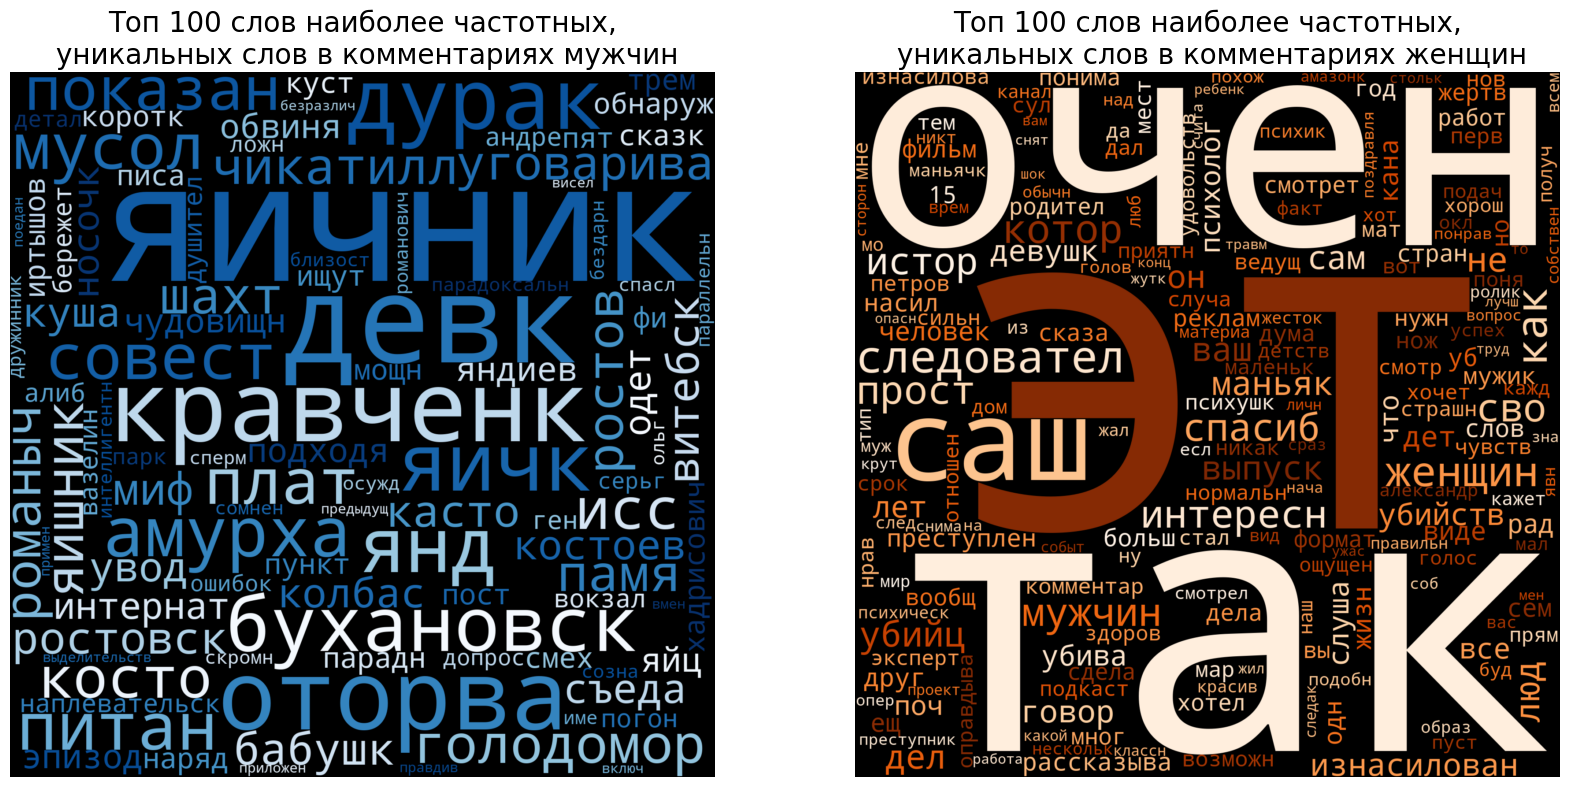

In [174]:
# Визуализация облаков слов
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].imshow(wordcloud_man, interpolation='bilinear')
ax[1].imshow(wordcloud_woman, interpolation='bilinear')

ax[0].set_title(
    f'Топ 100 слов наиболее частотных,\n уникальных слов в комментариях мужчин',
    fontsize=20
)
ax[1].set_title(
    f'Топ 100 слов наиболее частотных,\n уникальных слов в комментариях женщин',
    fontsize=20
)

ax[0].axis("off")
ax[1].axis("off")

plt.show()

Получение оценки токсичности комментария

In [175]:
# Выведем 5 случайных комментариев c оценкой негатива первого видео
for _ in range(5):

    source = comments_woman_df.sample(n=1)
    text_clear = source['text_clear'].values[0]
    text = source['comment'].values[0]

    print(text)

    tf_idf_text = count_idf.transform([text_clear])

    toxic_proba = model_lr_base.predict_proba(tf_idf_text)

    print('Вероятность негатива: ', toxic_proba[:, 0])
    print()

Надеюсь больше не увижу данного следователя в роликах 
Вероятность негатива:  [0.50259479]

Изнасилование уничтожило её душу и жизнь. 
Вероятность негатива:  [0.60111437]

да по ее внешнему виду видно что она больна,черты лица явно неочень здорового человека
Вероятность негатива:  [0.53977495]

Меня поражает следователь..ну,чуть-чуть изнасиловали,с кем не бывает,ну,обычная хорошая семья..ну,мать подала заявление на дочь,как правильная мать.Слишком много личного видения следователя.Очень много вопросов именно к его оценке событий.
Вероятность негатива:  [0.58533152]

Тут многие расстроились, что вы ушли, но теперь понятно куда и зачем. Успехов вам! Мне нравился формат когда вы сидели и обсуждали вместе все и можно так же сейчас с психологом и следователями по делам. Очень ждём новые видео
Вероятность негатива:  [0.65537679]



In [176]:
# Выведем 5 случайных комментариев c оценкой негатива второго видео
for _ in range(5):

    source = comments_man_df.sample(n=1)
    text_clear = source['text_clear'].values[0]
    text = source['comment'].values[0]

    print(text)

    tf_idf_text = count_idf.transform([text_clear])

    toxic_proba = model_lr_base.predict_proba(tf_idf_text)

    print('Вероятность негатива: ', toxic_proba[:, 0])
    print()

мне "нравится" название ролика, такое громкое и интригующее типа "как ловили и как им это удалось????" подразумевающее будто это было супер сложно и чуть ли не сюжет триллера, а по факту она попалась как лохуха... пол часа жизни в пустую в ожидании интересного расследования-поиска.
Вероятность негатива:  [0.78694113]

В смысле экранизировать???Мало нам фильм про Чикатило или интервью скопцевского маньяка.Таких людей надо клеймить с позором на всю жизнь.Про героев не снимают,а про убийц,насильников,пожалуйста.
Вероятность негатива:  [0.76415483]

Откуда у мужика яичники???
Вероятность негатива:  [0.5128989]

Спасибо 
Вероятность негатива:  [0.57626267]

мне так нравиться как мужичок в красной футболке оправдывает насилие всё время повторяя что "ничего такого" и "всё в пределах нормы". милота. и главное рассуждает о жизни девочки подростка словно специалист по молодым женщинам, их развитию в обществе и психике. пиздец - одним словом.
Вероятность негатива:  [0.54895986]



In [177]:
# Получим оценки негатива для всех комментариев первого и второго видео

woman_tf_idf = count_idf.transform(comments_woman_df['text_clear'])
man_tf_idf = count_idf.transform(comments_man_df['text_clear'])

putin_negative_proba = model_lr_base.predict_proba(woman_tf_idf)
shulman_negative_proba = model_lr_base.predict_proba(man_tf_idf)

comments_woman_df['negative_proba'] = putin_negative_proba[:, 0]
comments_man_df['negative_proba'] = shulman_negative_proba[:, 0]

Найдем доли токсичных комментариев при оптимальном пороговом значении

In [183]:
woman_share_neg = (comments_woman_df['negative_proba'] >  0.575758).sum() / comments_woman_df.shape[0]
woman_share_neg

0.766156462585034

In [184]:
man_share_neg = (comments_man_df['negative_proba'] >  0.575758).sum() / comments_man_df.shape[0]
man_share_neg

0.7492447129909365

In [186]:
fig = make_subplots(1,1,
                   subplot_titles=['Распределение комментариев по оценке негативности']     
                   )

fig.add_trace(go.Violin(
    x = comments_man_df['negative_proba'],
    meanline_visible = True,
    name = 'man (N = %i)' % comments_woman_df.shape[0],
    side = 'positive',
    spanmode = 'hard'
))



fig.add_trace(go.Violin(
    x = comments_woman_df['negative_proba'],
    meanline_visible = True,
    name = 'woman (N = %i)' % comments_man_df.shape[0],
    side = 'positive',
    spanmode = 'hard'
))


fig.add_annotation(x=0.8, y=1.5,
            text = "%0.2f — доля негативных комментариев (при p >  0.575758)"\
                   % woman_share_neg,
            showarrow=False,
            yshift=10)

fig.add_annotation(x=0.8, y=0.5,
            text = "%0.2f — доля негативных комментариев (при p >  0.575758)"\
                   % man_share_neg,
            showarrow=False,
            yshift=10)

fig.update_traces(orientation='h', 
                  width = 1.5,
                  points = False
                 )


fig.update_layout(height = 500,
                  #xaxis_showgrid=False,
                  xaxis_zeroline=False,
                  template = 'plotly_dark',
                  font_color = 'rgba(212, 210, 210, 1)',
                  legend=dict(
                    y=0.9,
                    x=-0.1,
                    yanchor='top',
                    ),
                 )
fig.update_yaxes(visible = False)
              


fig.show()

## Улучшение модели *

Попробуем подобрать коэффициен регуляризации с

In [187]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )
    )
])

In [188]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.688 total time=   0.3s
[CV 2/3] END .............................C=0.1;, score=0.686 total time=   0.1s
[CV 3/3] END .............................C=0.1;, score=0.686 total time=   0.3s
[CV 1/3] END ...............................C=1;, score=0.835 total time=   0.2s
[CV 2/3] END ...............................C=1;, score=0.833 total time=   0.3s
[CV 3/3] END ...............................C=1;, score=0.839 total time=   0.2s


/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 1/3] END ............................C=10.0;, score=0.863 total time=   0.3s


/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 2/3] END ............................C=10.0;, score=0.860 total time=   0.4s


/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV 3/3] END ............................C=10.0;, score=0.867 total time=   0.4s


/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fe93fd7ddc0>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [189]:
best_params = grid_pipeline.named_steps['model'].best_params_
best_score = grid_pipeline.named_steps['model'].best_score_

print("Лучшие параметры:", best_params)
print("Наилучшая оценка:", best_score)


Лучшие параметры: {'C': 10.0}
Наилучшая оценка: 0.8633553959069994


In [190]:
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
]
)
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fe92a5e6700>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [191]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])

In [193]:
indices_high_precision = np.where(prec_c_10 > 0.95)[0]
indices_high_precision
max_recall_index = indices_high_precision[np.argmax(rec_c_10[indices_high_precision])]
threshold_with_max_recall = thresholds_c_10[max_recall_index]
max_recall_value = rec_c_10[max_recall_index]

print(f"Threshold with precision > 0.95 and maximum recall: {max_recall_index}")
print(f"Maximum recall at this threshold: {max_recall_value}")

Threshold with precision > 0.95 and maximum recall: 416
Maximum recall at this threshold: 0.5031847133757962


In [194]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[432])

0.9696969696969697

In [195]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[432])

0.40764331210191085